In [1]:
!pip install scikit-activeml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iteration-utilities: filename=iteration_utilities-0.11.0-cp310-cp310-linux_x86_64.whl size=327918 sha256=3823f05d0390869c4d418c08215d06b1e11b3c74687989d38a6d5bf5ef30fcf8
  Stored in directory: /root/.cache/pip/wheels/2d/ab/c4/309aa5942beba1f36d6744acf619b7a314fca50f6a7ccce68c
Successfully built iteration-utilities
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: joblib
    Found existing installation

In [1]:
from sklearn.datasets import load_iris, load_digits
from skactiveml.classifier import SklearnClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skactiveml.utils import MISSING_LABEL, labeled_indices, unlabeled_indices
from skactiveml.visualization import plot_utilities, plot_decision_boundary

from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from skactiveml.pool import UncertaintySampling,RandomSampling
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.metrics import f1_score


In [2]:
df = pd.read_csv(r"/content/bmi.csv")
df=df.drop(columns=['Gender'])
X = df.drop(columns=['Index'])
y_true = df['Index']

In [3]:
X

,Height,Weight
0,174,96
1,189,87
2,185,110
3,195,104
4,149,61
...,...,...
495,150,153
496,184,121
497,141,136
498,150,95


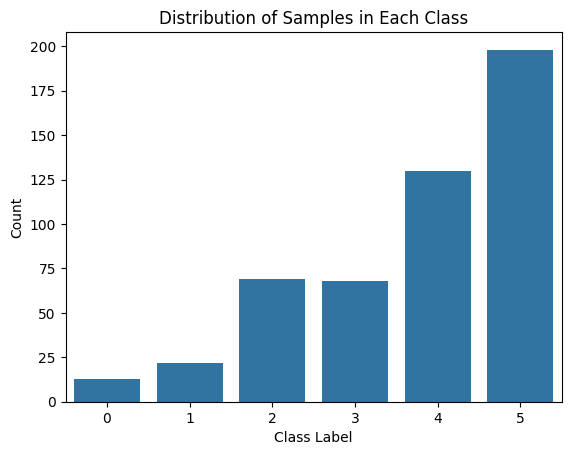

In [4]:
sns.countplot(data=df, x='Index')
plt.title('Distribution of Samples in Each Class')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

In [6]:
clf = SklearnClassifier(RandomForestClassifier(), classes=np.unique(y_true))

# Query Strategies
query_strategies = {
    'Least Confidence': UncertaintySampling(method='least_confident', random_state=42),
    'Entropy': UncertaintySampling(method='entropy', random_state=42),
    'Margin': UncertaintySampling(method='margin_sampling', random_state=42)
}
accuracy_results = {strategy_name: [] for strategy_name in query_strategies}
f1_score_results = {strategy_name: [] for strategy_name in query_strategies}  # Initialize F1 score results
# Number of cycles
n_cycles = 20

for strategy_name, qs in query_strategies.items():
    # Initialize labeled data
    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
    clf.fit(X , y)

    accuracy_list = []
    f1_score_list = []  # Initialize F1 score list
    # Active learning loop
    for c in range(n_cycles):
        # Query
        query_idx = qs.query(X=X , y=y, clf=clf, batch_size=10)

        # Label acquired samples
        y[query_idx] = y_true[query_idx]

        # Retrain classifier
        clf.fit(X , y)

        # Calculate accuracy
        accuracy = clf.score(X, y_true)
        accuracy_list.append(accuracy)

        # Calculate F1 score
        y_pred = clf.predict(X)
        f1 = f1_score(y_true, y_pred, average='weighted')
        f1_score_list.append(f1)

        # Print results
        print(f'Query Strategy: {strategy_name}, Iteration: {c+1}, Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')

        unlbld_idx = unlabeled_indices(y)
        lbld_idx = labeled_indices(y)

    accuracy_results[strategy_name] = accuracy_list
    f1_score_results[strategy_name] = f1_score_list  # Store F1 score results

Query Strategy: Least Confidence, Iteration: 1, Accuracy: 0.57, F1 Score: 0.54
Query Strategy: Least Confidence, Iteration: 2, Accuracy: 0.60, F1 Score: 0.60
Query Strategy: Least Confidence, Iteration: 3, Accuracy: 0.66, F1 Score: 0.65
Query Strategy: Least Confidence, Iteration: 4, Accuracy: 0.68, F1 Score: 0.68
Query Strategy: Least Confidence, Iteration: 5, Accuracy: 0.67, F1 Score: 0.68
Query Strategy: Least Confidence, Iteration: 6, Accuracy: 0.71, F1 Score: 0.72
Query Strategy: Least Confidence, Iteration: 7, Accuracy: 0.76, F1 Score: 0.76
Query Strategy: Least Confidence, Iteration: 8, Accuracy: 0.80, F1 Score: 0.80
Query Strategy: Least Confidence, Iteration: 9, Accuracy: 0.83, F1 Score: 0.83
Query Strategy: Least Confidence, Iteration: 10, Accuracy: 0.86, F1 Score: 0.86
Query Strategy: Least Confidence, Iteration: 11, Accuracy: 0.87, F1 Score: 0.87
Query Strategy: Least Confidence, Iteration: 12, Accuracy: 0.87, F1 Score: 0.88
Query Strategy: Least Confidence, Iteration: 13, 

In [7]:
qs = RandomSampling()
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf.fit(X , y)

accuracy_list = []
f1_score_list = []  # Initialize F1 score list
# Active learning loop
for c in range(n_cycles):
    # Query
    query_idx = qs.query(X=X , y=y, batch_size=10)

    # Label acquired samples
    y[query_idx] = y_true[query_idx]

    # Retrain classifier
    clf.fit(X , y)

    # Calculate accuracy
    accuracy = clf.score(X, y_true)
    accuracy_list.append(accuracy)

    # Calculate F1 score
    y_pred = clf.predict(X)
    f1 = f1_score(y_true, y_pred, average='weighted')
    f1_score_list.append(f1)

    # Print results
    print(f'In Random Sampling, Iteration: {c+1}, Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')

    unlbld_idx = unlabeled_indices(y)
    lbld_idx = labeled_indices(y)

# Update to add random sampling with accuracy.
accuracy_results.update({
    "Random Sampling":accuracy_list
})
f1_score_results.update({
    "Random Sampling":f1_score_list
})

In Random Sampling, Iteration: 1, Accuracy: 0.62, F1 Score: 0.59
In Random Sampling, Iteration: 2, Accuracy: 0.59, F1 Score: 0.56
In Random Sampling, Iteration: 3, Accuracy: 0.72, F1 Score: 0.69
In Random Sampling, Iteration: 4, Accuracy: 0.75, F1 Score: 0.73
In Random Sampling, Iteration: 5, Accuracy: 0.73, F1 Score: 0.71
In Random Sampling, Iteration: 6, Accuracy: 0.77, F1 Score: 0.76
In Random Sampling, Iteration: 7, Accuracy: 0.80, F1 Score: 0.79
In Random Sampling, Iteration: 8, Accuracy: 0.83, F1 Score: 0.83
In Random Sampling, Iteration: 9, Accuracy: 0.83, F1 Score: 0.83
In Random Sampling, Iteration: 10, Accuracy: 0.85, F1 Score: 0.85
In Random Sampling, Iteration: 11, Accuracy: 0.86, F1 Score: 0.86
In Random Sampling, Iteration: 12, Accuracy: 0.85, F1 Score: 0.84
In Random Sampling, Iteration: 13, Accuracy: 0.86, F1 Score: 0.85
In Random Sampling, Iteration: 14, Accuracy: 0.86, F1 Score: 0.86
In Random Sampling, Iteration: 15, Accuracy: 0.87, F1 Score: 0.86
In Random Sampling,